# Single Node RNN prediction

## Experiment setting

In [1]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
training = False
#check if cuda is available
torch.cuda.is_available()

True

In [3]:
# Data
n_tracks = 5  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 100

# Training
batch_size = 32
latent_dim = 128
n_steps = 8000

# Sampling
sample_interval = 100  # interval to run the sampler (in step)
n_samples = 4

In [4]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)

## Data Preparation

In [5]:
if training==False:
    dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
    id_list = []
    for path in os.listdir("data/lpd_5/amg"):
        filepath = os.path.join("data/lpd_5/amg", path)
        if os.path.isfile(filepath):
            with open(filepath) as f:
                id_list.extend([line.rstrip() for line in f])
    id_list = list(set(id_list))
    
   # print(id_list)

In [6]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

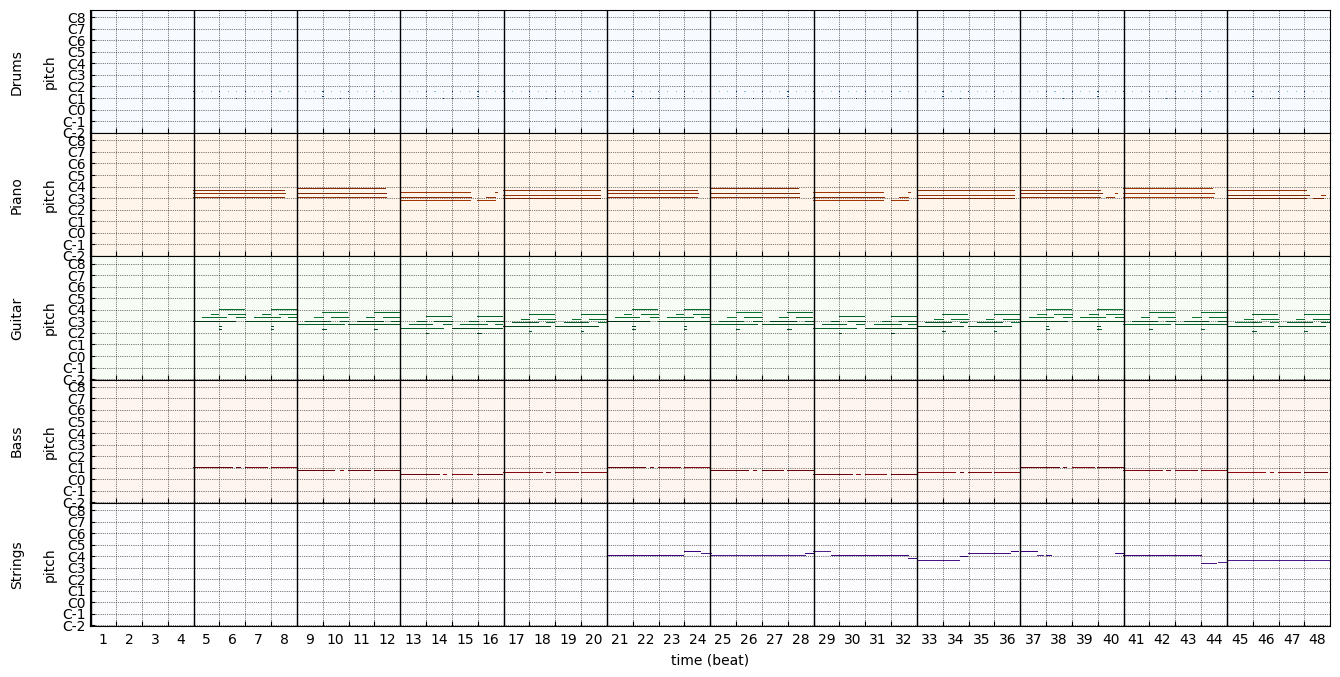

In [7]:
if training==False:
    song_dir = dataset_root / msd_id_to_dirs('TREVDFX128E07859E0') # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    multitrack.trim(end=12 * 96)
    axs = multitrack.plot()
    plt.gcf().set_size_inches((16, 8))
    for ax in axs:
        for x in range(96, 12 * 96, 96):     
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.show()

In [8]:
data = []
# Iterate over all the songs in the ID list
for msd_id in tqdm(id_list):
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root / msd_id_to_dirs(msd_id)
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}")

100%|██████████| 7323/7323 [04:47<00:00, 25.46it/s]


Successfully collect 26154 samples from 7323 songs
Data shape : (26154, 5, 64, 72)


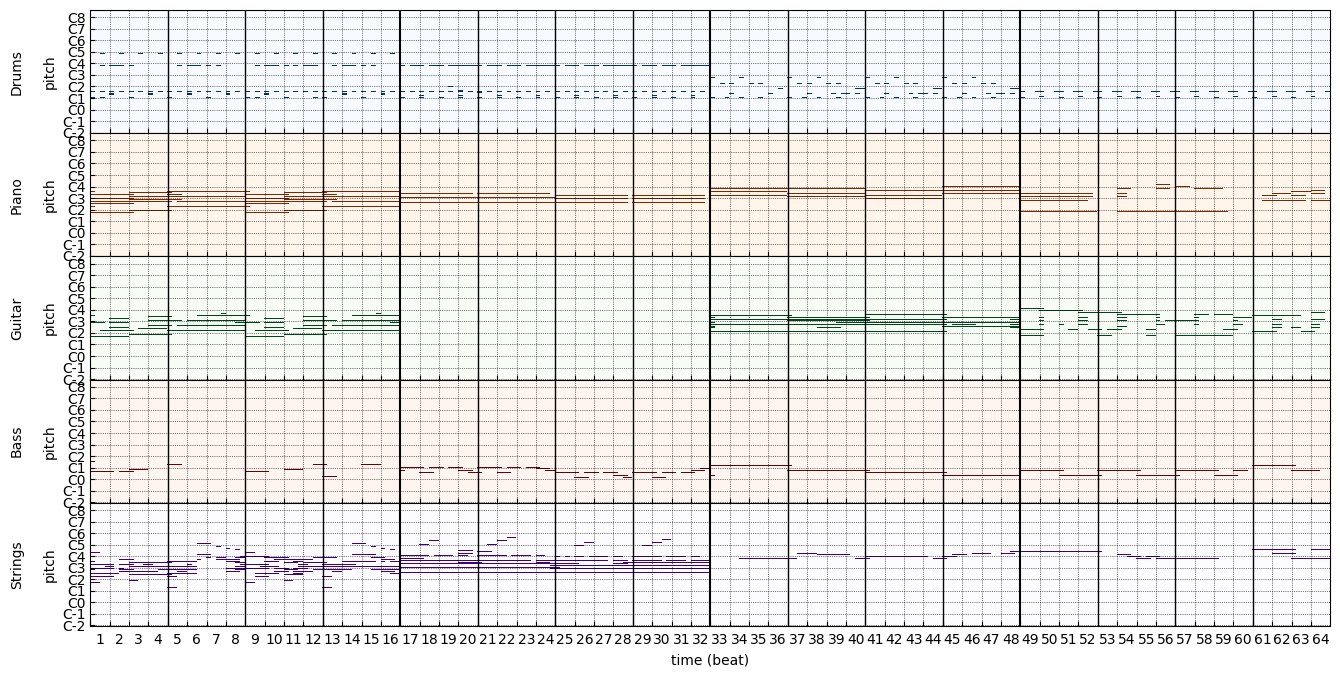

In [9]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

def prepare_data(data, n_pitches):
    # 将 NumPy 数组转换为 PyTorch 张量
    data = torch.tensor(data, dtype=torch.int64)

    # 选择第一个音轨，并展平时间步和音高
    data = data[:, 0, :, :].reshape(data.shape[0], -1)

    # 对音高进行 one-hot 编码
    data = torch.nn.functional.one_hot(data, num_classes=n_pitches).float()
    
    return data

prepared_data = prepare_data(data, n_pitches=72)


class MusicDataset(Dataset):
    def __init__(self, data, sequence_length):
        """
        data: 预处理后的音乐数据
        sequence_length: 输入序列的长度
        """
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return self.data.size(0) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

# 设置序列长度
sequence_length = 64  # 比如一个小节的长度

# 准备数据集
music_dataset = MusicDataset(prepared_data, sequence_length)

# 创建 DataLoader
data_loader = DataLoader(music_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


## Define the model

In [ ]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MusicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # 通过RNN
        out, hidden = self.rnn(x, hidden)
        # 变形输出以适应全连接层
        out = out.reshape(out.size(0) * out.size(1), self.hidden_size)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

## Training loop

In [ ]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch, (input_seq, target_seq) in enumerate(data_loader):
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        
        # 初始化隐藏状态
        hidden = model.init_hidden(input_seq.size(0))
        hidden = tuple([each.data for each in hidden])

        # 前向传播
        output, hidden = model(input_seq, hidden)

        # 计算损失
        loss = criterion(output, target_seq.view(-1).long())
        total_loss += loss.item()

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader)

# 参数设置
input_size = 72  # 输入大小（音高数量）
hidden_size = 128  # 隐藏层大小
output_size = 72  # 输出大小（音高数量）
num_layers = 2  # RNN层数

# 创建模型
model = MusicRNN(input_size, hidden_size, output_size, num_layers).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 数据加载器
# 注意：您需要根据实际数据创建数据加载器
# 这里未提供具体的数据加载器实现

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    loss = train(model, data_loader, criterion, optimizer, device)
    print(f'Epoch {epoch}, Loss: {loss}')
